# Genre identification and Song similarity






The dataset has the following files:

genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)

images original - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible (we'll be talking about this more in depth later)

2 CSV files - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file (more in depth later). The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

In [ ]:
#Loading basic libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading the ML Libraries
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#For the audio file processing , the updated framework available to public is the librosa package which we use in this study

In [ ]:
#Loading assistive libraries
import librosa
import librosa.display
import IPython.display as ipd

# Why Librosa?
## It provides us with a helper function to convert multichannel to monochannel and also it helpts to convert Sample Rate

# Sample Rate is how the Computer reads the audio file.
## -> measures how frequent the samples of the audio files are
## -> quality or detail of the audio file

### We can say that high sample rate gets more details of each wave in the audio file than low sample rates and also certain sample rates appear same to the eat because our ears can hear most at this rate

In [ ]:
# allows us to list all files to a directory
from glob import glob

In [ ]:
#The total available genres in the dataset

dir_ = '/content/drive/MyDrive/DS5500/data'
genre_count = list(os.listdir(f'{dir_}/genres_original/'))
print("The total number of genres in the dataset are : ",len(genre_count))

The total number of genres in the dataset are :  10


In [ ]:
# The number of audio files are :

audio_files = glob("/content/drive/MyDrive/DS5500/data/genres_original/*/*.wav")

print("The total audio files are :",len(audio_files))

The total audio files are : 1000


In [ ]:
#Lets listen to an audio file
ipd.Audio(audio_files[10])

How are we loading the Audio Files?

Here we use librosa and its load() function to read the audio files. We save the ouutputs as 'y' and sr':

## y: raw data of the audio file (numpy array)
## sr: integer value of the sample rate

In [ ]:
y, sr = librosa.load(audio_files[7])

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

y: [-0.05050659  0.26184082  0.3322754  ...  0.14788818  0.21975708
  0.08520508] 

y shape: (661504,) 

Sample Rate (KHz): 22050 



We can see that the raw data of our audiofiles (y) are numpy arrays and in this case our Sample Rate (sr) is 22050.

In [ ]:
audio, _ = librosa.effects.trim(y)

print('Audio File:', audio, '\n')
print('Audio File shape:', np.shape(audio))

Audio File: [-0.05050659  0.26184082  0.3322754  ...  0.14788818  0.21975708
  0.08520508] 

Audio File shape: (661504,)


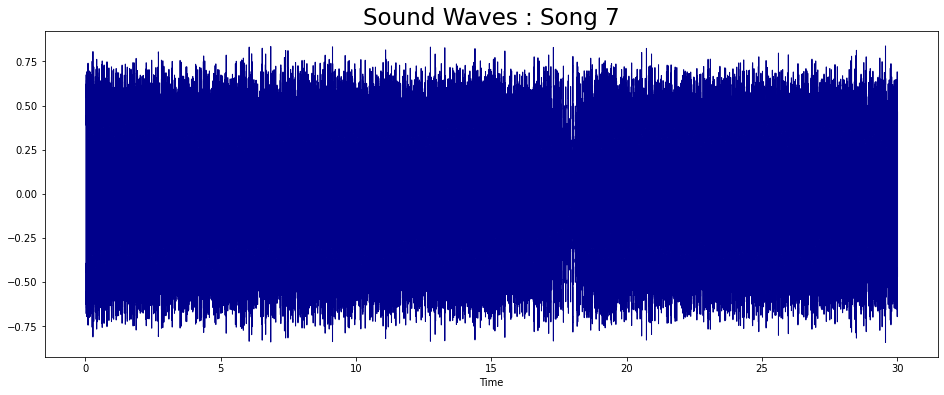

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = sr, color = "#00008B");
plt.title("Sound Waves : Song 7", fontsize = 23);

In [ ]:
ynot, srnot = librosa.load(audio_files[9])

print('y:', ynot, '\n')
print('y shape:', np.shape(ynot), '\n')
print('Sample Rate (KHz):', srnot, '\n')

y: [-0.04174805 -0.06900024 -0.04388428 ...  0.03582764  0.03430176
 -0.00180054] 

y shape: (661504,) 

Sample Rate (KHz): 22050 



In [ ]:
audionot, _ = librosa.effects.trim(ynot)

print('Audio File:', audionot, '\n')
print('Audio File shape:', np.shape(audionot))

Audio File: [-0.04174805 -0.06900024 -0.04388428 ...  0.03582764  0.03430176
 -0.00180054] 

Audio File shape: (661504,)


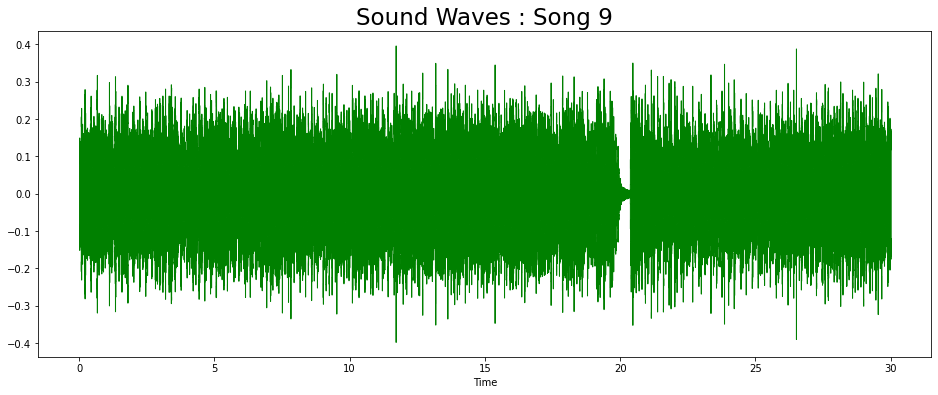

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audionot , sr = sr, color = "Green");
plt.title("Sound Waves : Song 9", fontsize = 23);

By comparing the strengths of the various frequencies, we hope to advance the situation.


We accomplish this by giving the audio data a Fourier transform. This enables us to determine which frequencies are audible at various points throughout the audio recording. The stft() function is employed (Short-time Fourier Transform).


Then, we utilize the amplitude to db function, a widely used audio data converter, to convert the STFT output's amplitude values to decibels (db).
With this, we obtain data that we can use to feed into standard ML models.

In [ ]:
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)


# Use STFT on raw audio data
D = librosa.stft(audio)
Dnot = librosa.stft(audionot)



# convert from aplitude to decibel values by taking the absolute value of D in reference what the max value would be
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_dbnot = librosa.amplitude_to_db(np.abs(Dnot), ref=np.max)



# see the shape of transformed data
print("New shape of transformed data", S_db.shape)
print("New shape of transformed data", S_dbnot.shape)

New shape of transformed data (1025, 1293)
New shape of transformed data (1025, 1293)


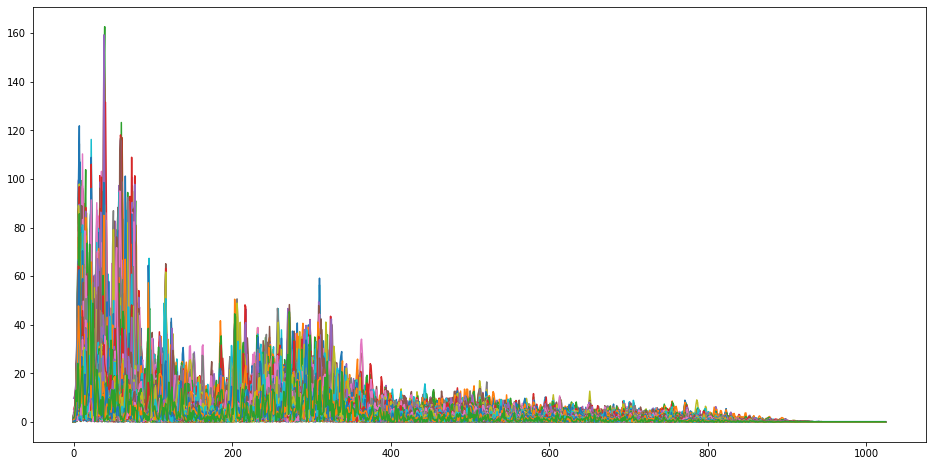

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(np.abs(D))
plt.show(plt.legend)

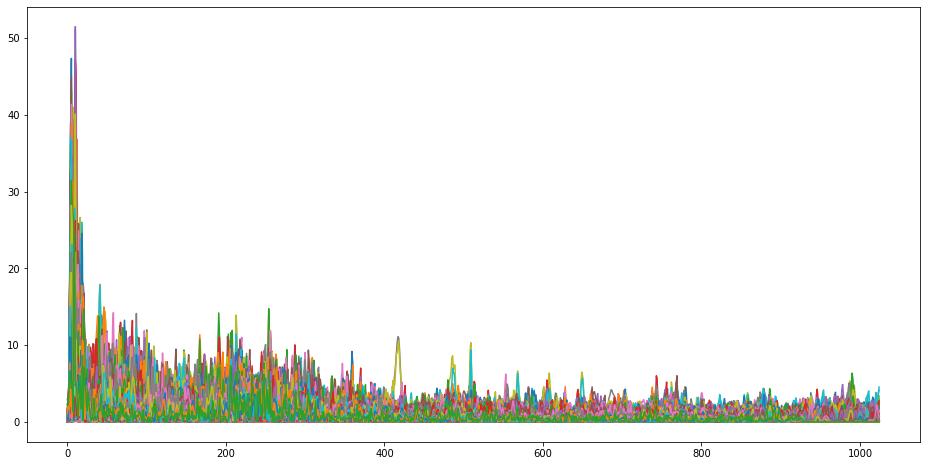

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(np.abs(Dnot))
plt.show(plt.legend)

Now we shall understand the spectrogram.

A spectrogram is a visual representation of the frequency spectrum of a sound signal over time. It displays the amplitude (or strength) of different frequencies present in the audio file as colors or shapes in a 2D graph, with time on the x-axis and frequency on the y-axis. Spectrograms are useful for analyzing and understanding the properties of sounds, identifying components or characteristics of audio signals, and troubleshooting audio-related problems.


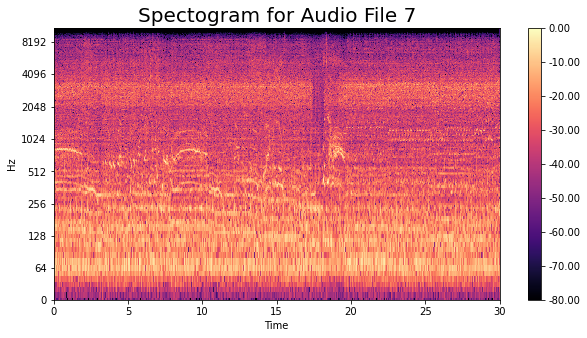

In [ ]:
# plot transformed data as spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectogram for Audio File 7', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

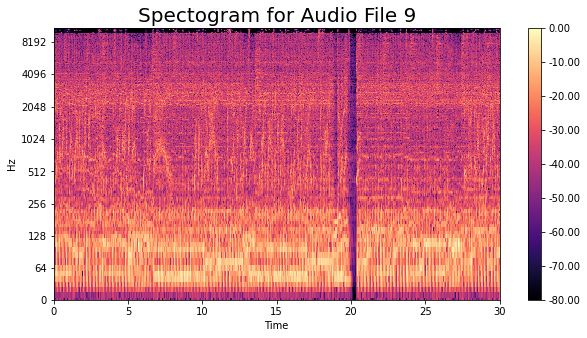

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_dbnot, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectogram for Audio File 9', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

A Mel Spectrogram is a type of spectrogram that is specifically designed to represent the perceived sound characteristics of human hearing. It uses the Mel scale, which is a logarithmic scale that depicts the non-linear frequency response of human ears, to provide a more meaningful representation of the audio signal than a linear frequency scale.

The Mel spectrogram represents the audio signal in terms of its Mel frequency coefficients, and it can be used in various applications such as speech and music processing, sound classification, and feature extraction for machine learning algorithms.

In [ ]:
# apply mel spectogram without STFT
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128*2)
Snot = librosa.feature.melspectrogram(ynot, sr=srnot, n_mels=128*2)

print("Shape of Mel Spectogram for 7", S.shape)
print("Shape of Mel Spectogram for 9", Snot.shape)

Shape of Mel Spectogram for 7 (256, 1293)
Shape of Mel Spectogram for 9 (256, 1293)


In [ ]:
# use that converting function as above
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
S_db_melnot = librosa.amplitude_to_db(Snot, ref=np.max)

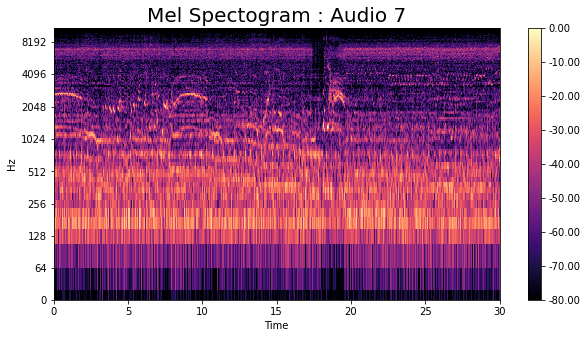

In [ ]:
# plot the mel spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram : Audio 7', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

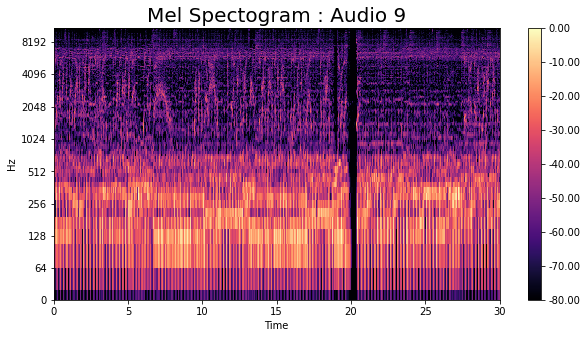

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_melnot, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram : Audio 9', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')

Zero Crossing Rate

ZCR is a measure of the number of times the amplitude of a signal crosses the zero axis per unit time i.e. the rate at which the signal changes from positive to negative or back.

To calculate the ZCR of a signal, we first segment the signal into frames of equal length. For each frame, we count the number of times the signal crosses the zero axis. The ZCR for the entire signal can then be computed as the average of the ZCR values for each frame.

In music analysis, the ZCR can be used to identify percussive sounds or changes in rhythm, since percussive sounds tend to have higher ZCR values due to their sharp, short-lived waveforms. It can also be used to identify noise-like segments of a music signal, such as white noise or static.

In [ ]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio, pad=False)
print(sum(zero_crossings))

113595


In [ ]:
zero_crossings_not = librosa.zero_crossings(audionot, pad=False)
print(sum(zero_crossings_not))

127458


Next we use harmonics and perecptruals

Harmonics are characteristichs that human years can't distinguish (represents the sound color)

Perceptrual understanding shock wave represents the sound rhythm and emotion

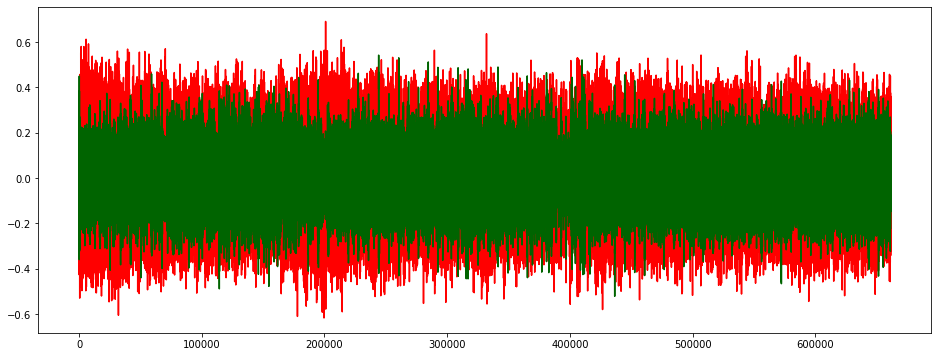

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#FF0000');
plt.plot(y_perc, color = '#006400');

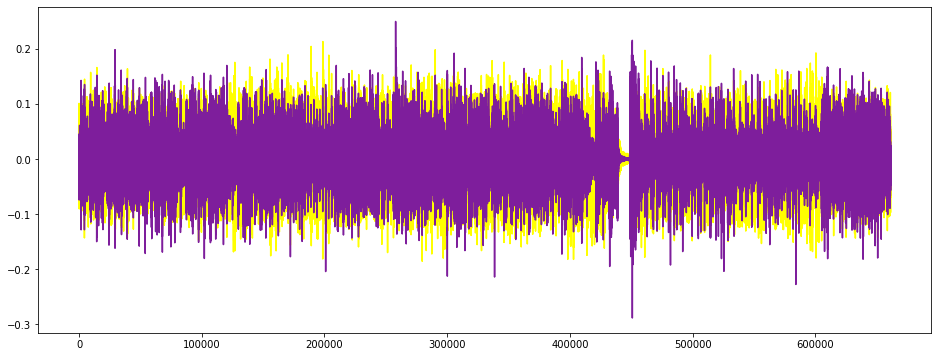

In [ ]:
y_harmnot, y_percnot = librosa.effects.hpss(audionot)

plt.figure(figsize = (16, 6))
plt.plot(y_harmnot, color = '#FFFF00');
plt.plot(y_percnot, color = '#7E1E9C');

Tempo

In [ ]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

161.4990234375

Spectral Centroid

indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

The spectral centroid is a measure of the center of gravity of the frequency content of a signal. It is often used as a descriptor of the tonal center or brightness of a sound.

The spectral centroid is calculated as the weighted mean of the frequencies present in the signal, with the magnitude spectrum of the signal serving as the weights. In other words, it is a way to compute the center of mass of the frequency distribution of a signal.

In [ ]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [2245.88562242 2323.55532565 2476.76817486 ... 2811.41956473 2701.88643365
 2562.52782055] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


In [ ]:
import sklearn

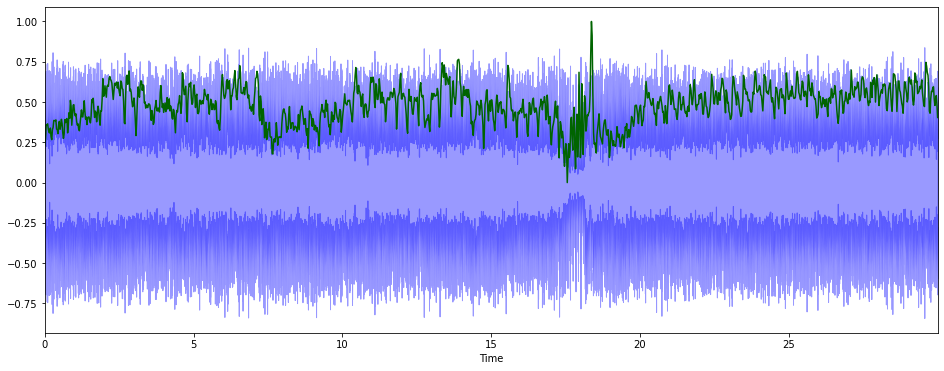

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio, sr=sr, alpha=0.4, color = '#0000FF');
plt.plot(t, normalize(spectral_centroids), color='#006400');

The x-axis represents time in seconds and the y-axis represents amplitude. The green line represents the spectral centroid, with brighter colors indicating a higher value.
This plot can help us visualize the tonal center of the sound, with a higher spectral centroid indicating a brighter or more tonal sound.

In [ ]:
spectral_centroids_not = librosa.feature.spectral_centroid(audionot, sr=srnot)[0]

print('Centroids:', spectral_centroids_not, '\n')
print('Shape of Spectral Centroids:', spectral_centroids_not.shape, '\n')

frame_not = range(len(spectral_centroids_not))

t_not = librosa.frames_to_time(frame_not)

print('frames:', frame_not, '\n')
print('t:', t_not)

Centroids: [3732.55308892 3949.68918262 3927.60186954 ... 2965.09470013 3225.09562336
 3385.08214584] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


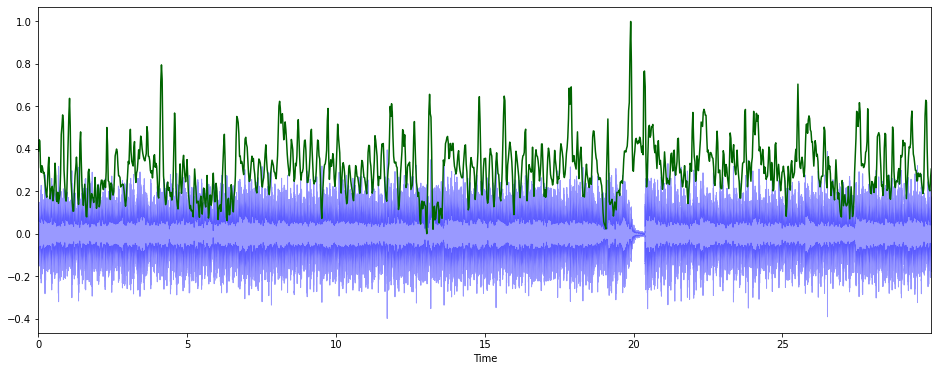

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audionot, sr=srnot, alpha=0.4, color = '#0000FF');
plt.plot(t_not, normalize(spectral_centroids_not), color='#006400');

If the spectral centroid is higher than the waveform, it means that the frequency content of the signal is weighted towards higher frequencies.

Now we use the feature extracted data to understand the audio files

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DS5500/data/features_3_sec.csv")
df.head(20)

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0   blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1   blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2   blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3   blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4   blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
5   blues.00000.5.wav   66149          0.376670         0.089702  0.132618   
6   blues.00000.6.wav   66149          0.379909         0.088827  0.130335   
7   blues.00000.7.wav   66149          0.331880         0.092119  0.140600   
8   blues.00000.8.wav   66149          0.347877         0.094209  0.133130   
9   blues.00000.9.wav   66149          0.358061         0.082957  0.115312   
10  blues.00001.0.wav   66149          0.402401         0.090340  0.093024   
11  blues.00001.1.wav   66149          0.345507         0.091037  0.094656   
12  blues.00001.2.wav   66149          0.338119         0.083682  0.097776   
13  blues.00001.3.wav   66149          0.330751         0.093936  0.085365   
14  blues.00001.4.wav   66149          0.348027         0.100096  0.088437   
15  blues.00001.5.wav   66149          0.329435         0.104149  0.093201   
16  blues.00001.6.wav   66149          0.343666         0.096098  0.089783   
17  blues.00001.7.wav   66149          0.327732         0.099648  0.110633   
18  blues.00001.8.wav   66149          0.329428         0.090254  0.111013   
19  blues.00001.9.wav   66149          0.292987         0.082145  0.094924   

     rms_var  spectral_centroid_mean  spectral_centroid_var  \
0   0.003521             1773.065032          167541.630869   
1   0.001450             1816.693777           90525.690866   
2   0.004620             1788.539719          111407.437613   
3   0.002448             1655.289045          111952.284517   
4   0.001701             1630.656199           79667.267654   
5   0.003583             1994.915219          211700.619569   
6   0.003166             1962.150096          177443.070045   
7   0.002546             1701.890924           35678.130616   
8   0.002538             1746.473502          138073.931244   
9   0.001846             1763.948942           61493.423121   
10  0.003876             1279.182242          406513.816744   
11  0.001495             1513.763969          214768.804443   
12  0.001386             1308.869728          154209.122448   
13  0.002641             1479.530348          646868.373151   
14  0.002204             1729.640428          568827.519152   
15  0.001929             1492.089309          228951.553214   
16  0.002173             1571.420445          257630.094708   
17  0.003306             1877.638297          510311.370648   
18  0.001072             1665.600276          239973.571541   
19  0.003031             1373.437553          210606.446462   

    spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0               1972.744388           117335.771563  ...   39.687145   
1               2010.051501            65671.875673  ...   64.748276   
2               2084.565132            75124.921716  ...   67.336563   
3               1960.039988            82913.639269  ...   47.739452   
4               1948.503884            60204.020268  ...   30.336359   
5               2152.767854            74263.873102  ...   31.448069   
6               2146.503479            98020.541422  ...   33.954071   
7               1979.387612            36670.725886  ...   38.456211   
8               1887.619723           117069.920049  ...   44.311455   
9               1874.195710            51944.921435  ...   43.967834   
10              1921.306192           196573.441648  ...   39.640743   
11              2091.432928           121877.017611  ...   58.940536   
12              1508.008806           111306.051891  ...   63.200188   
13              1906.454247           3577

In [ ]:
df.shape

(9990, 60)

In [ ]:
#df.isnull().sum()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

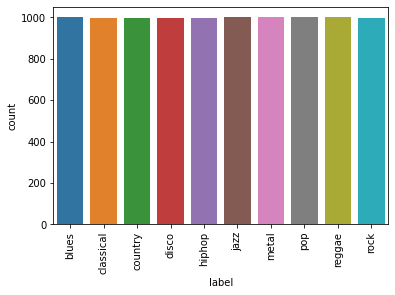

In [ ]:
sns.countplot(x=df.label) # plot the categories
plt.xticks(rotation=90)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 <a list of 28 Text major ticklabel objects>)

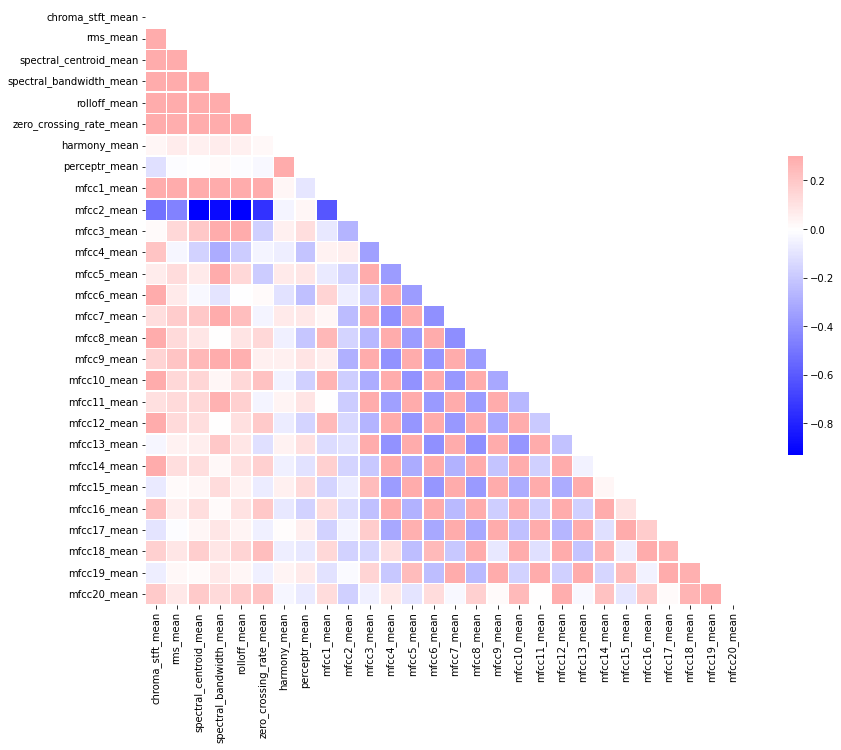

In [ ]:
spike = [col for col in df.columns if 'mean' in col]
corr = df[spike].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(16, 11));

sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

Text(0, 0.5, 'BPM')

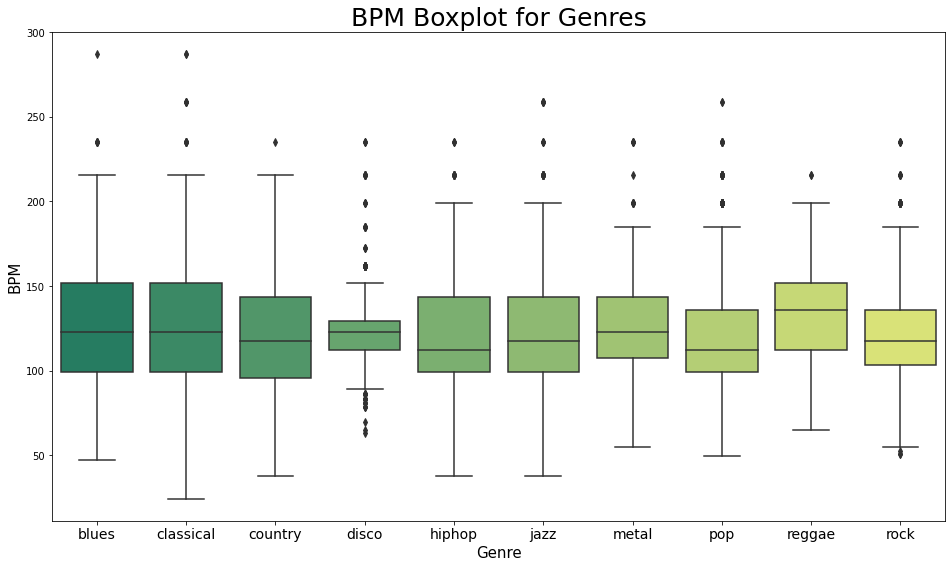

In [ ]:
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'summer');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
df = df.iloc[0:, 1:]
y = df['label']
X = df.loc[:, df.columns != 'label']

cols = X.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

pca = PCA(n_components=2)
scaled_df = pca.fit_transform(X)
df_p = pd.DataFrame(data = scaled_df, columns = ['pca1', 'pca2'])

fdf = pd.concat([df_p, y], axis = 1)

pca.explained_variance_ratio_

array([0.26799538, 0.18145817])

Text(0, 0.5, 'Principal Component 2')

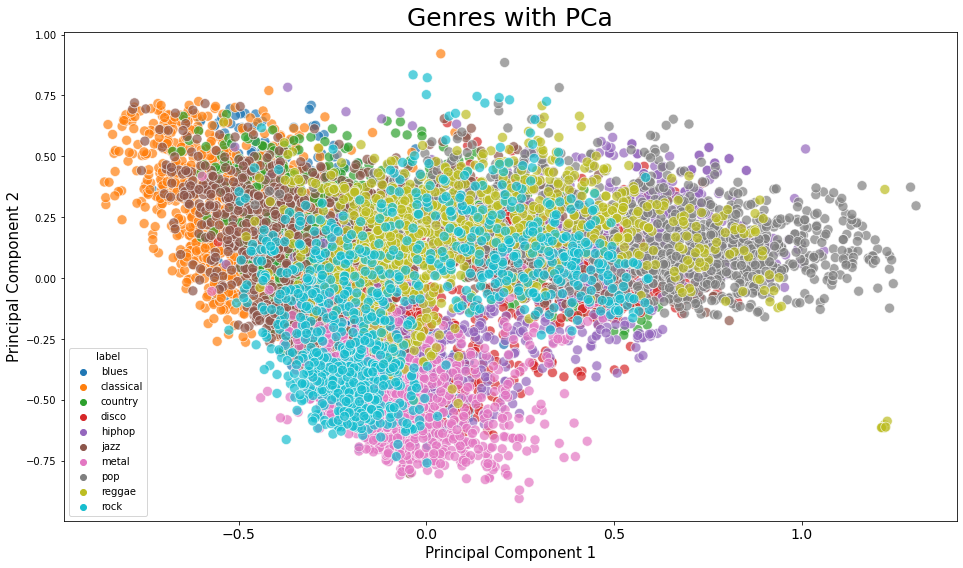

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pca1", y = "pca2", data = fdf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('Genres with PCa', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

In [ ]:
df

chroma_stft_var  rms_mean   rms_var  spectral_centroid_mean  \
0            0.091048  0.130405  0.003521             1773.065032   
1            0.086147  0.112699  0.001450             1816.693777   
2            0.092243  0.132003  0.004620             1788.539719   
3            0.086856  0.132565  0.002448             1655.289045   
4            0.088129  0.143289  0.001701             1630.656199   
...               ...       ...       ...                     ...   
9985         0.080515  0.050019  0.000097             1499.083005   
9986         0.082626  0.057897  0.000088             1847.965128   
9987         0.089019  0.052403  0.000701             1346.157659   
9988         0.084815  0.066430  0.000320             2084.515327   
9989         0.086759  0.050524  0.000067             1634.330126   

      spectral_centroid_var  spectral_bandwidth_mean  spectral_bandwidth_var  \
0             167541.630869              1972.744388           117335.771563   
1              90525.690866              2010.051501            65671.875673   
2             111407.437613              2084.565132            75124.921716   
3             111952.284517              1960.039988            82913.639269   
4              79667.267654              1948.503884            60204.020268   
...                     ...                      ...                     ...   
9985          164266.886443              1718.707215            85931.574523   
9986          281054.935973              1906.468492            99727.037054   
9987          662956.246325              1561.859087           138762.841945   
9988          203891.039161              2018.366254            22860.992562   
9989          411429.169769              1867.422378           119722.211518   

      rolloff_mean   rolloff_var  zero_crossing_rate_mean  ...  mfcc16_var  \
0      3714.560359  1.080790e+06                 0.081851  ...   39.687145   
1      3869.682242  6.722448e+05                 0.087173  ...   64.748276   
2      3997.639160  7.907127e+05                 0.071383  ...   67.336563   
3      3568.300218  9.216524e+05                 0.069426  ...   47.739452   
4      3469.992864  6.102111e+05                 0.070095  ...   30.336359   
...            ...           ...                      ...  ...         ...   
9985   3015.559458  8.479527e+05                 0.072885  ...   42.485981   
9986   3746.694524  1.170890e+06                 0.089111  ...   32.415203   
9987   2442.362154  2.602871e+06                 0.072194  ...   78.228149   
9988   4313.266226  4.968878e+05                 0.104072  ...   28.323744   
9989   3462.042142  1.517016e+06                 0.068495  ...   38.801735   

      mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0       -3.241280   36.488243     0.722209   38.099152    -5.050335   
1       -6.055294   40.677654     0.159015   51.264091    -2.837699   
2       -1.768610   28.348579     2.378768   45.717648    -1.938424   
3       -3.841155   28.337118     1.218588   34.770935    -3.580352   
4        0.664582   45.880913     1.689446   51.363583    -3.392489   
...           ...         ...          ...         ...          ...   
9985    -9.094270   38.326839    -4.246976   31.049839    -5.625813   
9986   -12.375726   66.418587    -3.081278   54.414265   -11.960546   
9987    -2.524483   21.778994     4.809936   25.980829     1.775686   
9988    -5.363541   17.209942     6.462601   21.442928     2.354765   
9989   -11.598399   58.983097    -0.178517   55.761299    -6.903252   

      mfcc19_var  mfcc20_mean  mfcc20_var  label  
0      33.618073    -0.243027   43.771767  blues  
1      97.030830     5.784063   59.943081  blues  
2      53.050835     2.517375   33.105122  blues  
3      50.836224     3.630866   32.023678  blues  
4      26.738789     0.536961   29.146694  blues  
...          ...          ...         ...    ...  
9985   48.804092     1.818823   38.966969   rock  
9986   63.452255  

In [ ]:
classes = df.iloc[:,-1]
converter = LabelEncoder()

In [ ]:
y = converter.fit_transform(classes)
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
x = scaler.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [ ]:
print(len(y_test))
print(len(y_train))

2498
7492


Here, we are performing a classification task where we are predicting an isntance is in some category by studying the instance's features.

For the following ML algorithms:

1) Scale the numeric features

2) encode the categorical features

XGBOOST

#n_estimators - number of weak learners to train in each iteration
#learning_rate - contributes to the weights of weak learners and has 1 as a default value.

In [ ]:
import xgboost as xgb


In [ ]:
xgb_classifier = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb_classifier.fit(x_train, y_train)
xgb_predicts = xgb_classifier.predict(x_test)

In [ ]:
xgb_accuracy = accuracy_score(y_test, xgb_predicts)
xgb_accuracy

0.888310648518815

ADABOOST

AdaBoost is a classification algorithm which calls a given weak learner algorithm repeatedly in a series of rounds. AdaBoost combines a numnber of weak learners to form a strong learner in order to achieve better separation between classes.

In [ ]:
ada_classifier = AdaBoostClassifier(n_estimators = 1000,learning_rate = 1)
ada_classifier.fit(x_train, y_train)
ada_predicts = ada_classifier.predict(x_test)

In [ ]:
ada_accuracy = accuracy_score(y_test, ada_predicts)
ada_accuracy

0.5240192153722978

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(x_train, y_train)
knn_predicts = knn.predict(x_test)

In [ ]:
knn_accuracy = accuracy_score(y_test, knn_predicts)
knn_accuracy

0.8162530024019216

SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(decision_function_shape="ovo")
svm.fit(x_train, y_train)
svm_predicts = svm.predict(x_test)

In [ ]:
svm_accuracy = accuracy_score(y_test, svm_predicts)
svm_accuracy

0.7522017614091273

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
rforest.fit(x_train, y_train)
rforest_predicts = rforest.predict(x_test)

In [ ]:
rforest_accuracy = accuracy_score(y_test, rforest_predicts)
rforest_accuracy

0.8142514011208967

Decison Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
tree_predicts = tree.predict(x_test)

In [ ]:
tree_accuracy = accuracy_score(y_test, tree_predicts)
tree_accuracy

0.6613290632506005

XGB is the model

confusion matrix is calculated

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [ ]:
cm = confusion_matrix(y_test, xgb_predicts)
np.set_printoptions(precision=5, suppress=True)

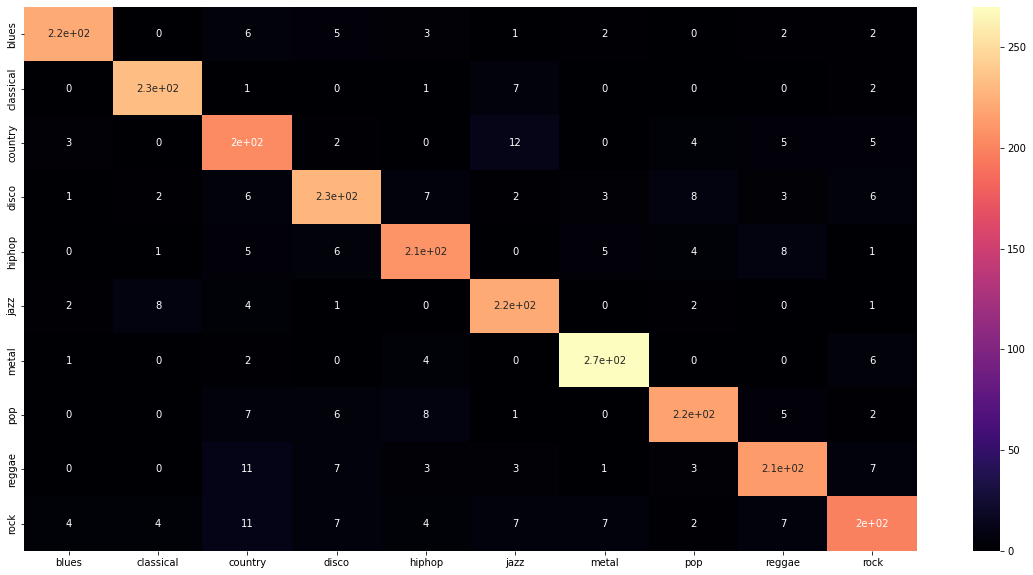

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(cm, cmap="magma", annot=True,
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")